## Model Training

## Models to Train:
1. Custom CNN (from scratch)
2. VGG16 (Transfer Learning)
3. ResNet50 (Transfer Learning)
4. MobileNet (Transfer Learning)
5. InceptionV3 (Transfer Learning)
6. EfficientNetB0 (Transfer Learning)

In [1]:
# Import all necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, Conv2D, MaxPooling2D,
    GlobalAveragePooling2D, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (
    VGG16, ResNet50, MobileNet, InceptionV3, EfficientNetB0
)
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

print("✓ Libraries imported")
print(f"TensorFlow version: {tf.__version__}")

✓ Libraries imported
TensorFlow version: 2.20.0


In [2]:
# Configuration
BASE_DIR = r'D:\Projects\MulticlassFishImageClassification\data'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'val')
TEST_DIR = os.path.join(BASE_DIR, 'test')

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 50
NUM_CLASSES = 11
LEARNING_RATE = 0.0001

print("✓ Configuration loaded")

✓ Configuration loaded


## 1. Load Data Generators and Class Weights

Run Part 2 notebook first, or recreate them here:

In [3]:
# Focal Loss function
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow((1 - y_pred), gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return focal_loss_fixed

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.4,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[0.6, 1.4]
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True, seed=42
)

valid_gen = valid_test_datagen.flow_from_directory(
    VALID_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

test_gen = valid_test_datagen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

# Compute aggressive class weights
class_labels = train_gen.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)
class_weights_aggressive = np.power(class_weights, 1.5)
class_weights_aggressive = class_weights_aggressive / class_weights_aggressive.min()
class_weight_dict = dict(enumerate(class_weights_aggressive))

print("✓ Data generators created")
print(f"✓ Class weights computed (aggressive scaling applied)")
print(f"Training samples: {train_gen.samples}")
print(f"Validation samples: {valid_gen.samples}")
print(f"Test samples: {test_gen.samples}")

Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.
✓ Data generators created
✓ Class weights computed (aggressive scaling applied)
Training samples: 6225
Validation samples: 1092
Test samples: 3187


In [4]:
# Callbacks
def get_callbacks(model_name, patience=15):
    return [
        EarlyStopping(
            monitor='val_loss', patience=patience,
            restore_best_weights=True, verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=5,
            min_lr=1e-7, verbose=1
        ),
        ModelCheckpoint(
            filepath=f'models/{model_name}_best.h5',
            monitor='val_accuracy', save_best_only=True, verbose=1
        )
    ]

# Plot training history
def plot_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.plot(history.history['accuracy'], label='Train')
    ax1.plot(history.history['val_accuracy'], label='Val')
    ax1.set_title(f'{model_name} - Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(history.history['loss'], label='Train')
    ax2.plot(history.history['val_loss'], label='Val')
    ax2.set_title(f'{model_name} - Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'results/plots/{model_name}_history.png', dpi=300)
    plt.show()
    
    pd.DataFrame(history.history).to_csv(
        f'results/metrics/{model_name}_history.csv', index=False
    )

print("✓ Helper functions defined")

✓ Helper functions defined


## 2. Model 1: Custom CNN

TRAINING MODEL 1: CUSTOM CNN

Model Architecture:


Model: "CustomCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,32

 Total params: 26,408,875 (100.74 MB)

 Trainable params: 26,407,915 (100.74 MB)

 Non-trainable params: 960 (3.75 KB)


Starting training...
Epoch 1/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1707 - loss: 3.7751
Epoch 1: val_accuracy improved from None to 0.22070, saving model to models/CustomCNN_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 855s 2s/step - accuracy: 0.2048 - loss: 2.9190 - val_accuracy: 0.2207 - val_loss: 0.4655 - learning_rate: 1.0000e-04
Epoch 2/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2423 - loss: 2.0199
Epoch 2: val_accuracy improved from 0.22070 to 0.29121, saving model to models/CustomCNN_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 748s 2s/step - accuracy: 0.2427 - loss: 1.8787 - val_accuracy: 0.2912 - val_loss: 0.3798 - learning_rate: 1.0000e-04
Epoch 3/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2707 - loss: 1.5851
Epoch 3: val_accuracy improved from 0.29121 to 0.35714, saving model to models/CustomCNN_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 755s 2s/step - accuracy: 0.2675 - loss: 1.6292 - val_accuracy: 0.3571 - val_loss: 0.3504 - learning_rate: 1.0000e-04
Epoch 4/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2835 - loss: 1.4040
Epoch 4: val_accuracy did not improve from 0.35714
390/390 ━━━━━━━━━━━━━━━━━━━━ 722s 2s/step - accuracy: 0.2924 - loss: 1.4477 - val_accuracy: 0.3214 - val_loss: 0.3686 - learning_rate: 1.0000e-04
Epoch 5/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2812 - loss: 1.3898
Epoch 5: val_accuracy improved from 0.35714 to 0.38187, saving model to models/CustomCNN_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 722s 2s/step - accuracy: 0.2829 - loss: 1.4431 - val_accuracy: 0.3819 - val_loss: 0.3275 - learning_rate: 1.0000e-04
Epoch 6/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3110 - loss: 1.5470
Epoch 6: val_accuracy improved from 0.38187 to 0.42766, saving model to models/CustomCNN_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 820s 2s/step - accuracy: 0.3033 - loss: 1.4056 - val_accuracy: 0.4277 - val_loss: 0.2992 - learning_rate: 1.0000e-04
Epoch 7/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3172 - loss: 1.3466
Epoch 7: val_accuracy did not improve from 0.42766
390/390 ━━━━━━━━━━━━━━━━━━━━ 798s 2s/step - accuracy: 0.3157 - loss: 1.3528 - val_accuracy: 0.3736 - val_loss: 0.3235 - learning_rate: 1.0000e-04
Epoch 8/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3414 - loss: 1.2841
Epoch 8: val_accuracy did not improve from 0.42766
390/390 ━━━━━━━━━━━━━━━━━━━━ 743s 2s/step - accuracy: 0.3425 - loss: 1.2842 - val_accuracy: 0.3251 - val_loss: 0.3542 - learning_rate: 1.0000e-04
Epoch 9/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3487 - loss: 1.3426
Epoch 9: val_accuracy did not improve from 0.42766
390/390 ━━━━━━━━━━━━━━━━━━━━ 703s 2s/step - accuracy: 0.3536 - loss: 1.2617 - val_accuracy: 0.2747 - val_loss: 0.4666 - learning_rate: 1.0000e-04
Epoch 10

390/390 ━━━━━━━━━━━━━━━━━━━━ 702s 2s/step - accuracy: 0.3680 - loss: 1.2052 - val_accuracy: 0.4780 - val_loss: 0.2309 - learning_rate: 1.0000e-04
Epoch 13/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3704 - loss: 1.1985
Epoch 13: val_accuracy did not improve from 0.47802
390/390 ━━━━━━━━━━━━━━━━━━━━ 706s 2s/step - accuracy: 0.3729 - loss: 1.1745 - val_accuracy: 0.3883 - val_loss: 0.2861 - learning_rate: 1.0000e-04
Epoch 14/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3653 - loss: 1.2073
Epoch 14: val_accuracy did not improve from 0.47802
390/390 ━━━━━━━━━━━━━━━━━━━━ 648s 2s/step - accuracy: 0.3679 - loss: 1.1950 - val_accuracy: 0.4560 - val_loss: 0.2358 - learning_rate: 1.0000e-04
Epoch 15/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3850 - loss: 1.1197
Epoch 15: val_accuracy did not improve from 0.47802
390/390 ━━━━━━━━━━━━━━━━━━━━ 971s 2s/step - accuracy: 0.3835 - loss: 1.1243 - val_accuracy: 0.3388 - val_loss: 0.3321 - learning_rate: 1.0000e-04
Ep

390/390 ━━━━━━━━━━━━━━━━━━━━ 1129s 3s/step - accuracy: 0.4031 - loss: 1.0996 - val_accuracy: 0.5440 - val_loss: 0.1818 - learning_rate: 1.0000e-04
Epoch 17/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3974 - loss: 1.0921
Epoch 17: val_accuracy did not improve from 0.54396
390/390 ━━━━━━━━━━━━━━━━━━━━ 919s 2s/step - accuracy: 0.4031 - loss: 1.0941 - val_accuracy: 0.5073 - val_loss: 0.2266 - learning_rate: 1.0000e-04
Epoch 18/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4060 - loss: 1.1174
Epoch 18: val_accuracy did not improve from 0.54396
390/390 ━━━━━━━━━━━━━━━━━━━━ 640s 2s/step - accuracy: 0.4095 - loss: 1.0981 - val_accuracy: 0.4414 - val_loss: 0.2711 - learning_rate: 1.0000e-04
Epoch 19/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4071 - loss: 1.1515
Epoch 19: val_accuracy improved from 0.54396 to 0.61813, saving model to models/CustomCNN_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 644s 2s/step - accuracy: 0.4079 - loss: 1.0634 - val_accuracy: 0.6181 - val_loss: 0.1655 - learning_rate: 1.0000e-04
Epoch 20/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4455 - loss: 0.9118
Epoch 20: val_accuracy did not improve from 0.61813
390/390 ━━━━━━━━━━━━━━━━━━━━ 646s 2s/step - accuracy: 0.4422 - loss: 0.9889 - val_accuracy: 0.3342 - val_loss: 0.3560 - learning_rate: 1.0000e-04
Epoch 21/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4400 - loss: 1.0701
Epoch 21: val_accuracy did not improve from 0.61813
390/390 ━━━━━━━━━━━━━━━━━━━━ 653s 2s/step - accuracy: 0.4296 - loss: 1.0278 - val_accuracy: 0.4817 - val_loss: 0.2292 - learning_rate: 1.0000e-04
Epoch 22/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4309 - loss: 0.9373
Epoch 22: val_accuracy did not improve from 0.61813
390/390 ━━━━━━━━━━━━━━━━━━━━ 640s 2s/step - accuracy: 0.4474 - loss: 0.9280 - val_accuracy: 0.5650 - val_loss: 0.1683 - learning_rate: 1.0000e-04
Ep

390/390 ━━━━━━━━━━━━━━━━━━━━ 636s 2s/step - accuracy: 0.4721 - loss: 0.8926 - val_accuracy: 0.6255 - val_loss: 0.1365 - learning_rate: 1.0000e-04
Epoch 25/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4736 - loss: 0.8156
Epoch 25: val_accuracy improved from 0.62546 to 0.68864, saving model to models/CustomCNN_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 638s 2s/step - accuracy: 0.4835 - loss: 0.8676 - val_accuracy: 0.6886 - val_loss: 0.1173 - learning_rate: 1.0000e-04
Epoch 26/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4907 - loss: 0.8841
Epoch 26: val_accuracy did not improve from 0.68864
390/390 ━━━━━━━━━━━━━━━━━━━━ 639s 2s/step - accuracy: 0.4933 - loss: 0.7934 - val_accuracy: 0.6071 - val_loss: 0.1605 - learning_rate: 1.0000e-04
Epoch 27/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5268 - loss: 0.6969
Epoch 27: val_accuracy did not improve from 0.68864
390/390 ━━━━━━━━━━━━━━━━━━━━ 638s 2s/step - accuracy: 0.5205 - loss: 0.7813 - val_accuracy: 0.5723 - val_loss: 0.1641 - learning_rate: 1.0000e-04
Epoch 28/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5144 - loss: 0.8787
Epoch 28: val_accuracy improved from 0.68864 to 0.77381, saving model to models/CustomCNN_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 637s 2s/step - accuracy: 0.5174 - loss: 0.7714 - val_accuracy: 0.7738 - val_loss: 0.0942 - learning_rate: 1.0000e-04
Epoch 29/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5234 - loss: 0.7175
Epoch 29: val_accuracy improved from 0.77381 to 0.79029, saving model to models/CustomCNN_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 684s 2s/step - accuracy: 0.5332 - loss: 0.7363 - val_accuracy: 0.7903 - val_loss: 0.0856 - learning_rate: 1.0000e-04
Epoch 30/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5506 - loss: 0.6354
Epoch 30: val_accuracy did not improve from 0.79029
390/390 ━━━━━━━━━━━━━━━━━━━━ 677s 2s/step - accuracy: 0.5388 - loss: 0.7034 - val_accuracy: 0.6364 - val_loss: 0.1323 - learning_rate: 1.0000e-04
Epoch 31/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5434 - loss: 0.7937
Epoch 31: val_accuracy did not improve from 0.79029
390/390 ━━━━━━━━━━━━━━━━━━━━ 643s 2s/step - accuracy: 0.5545 - loss: 0.7105 - val_accuracy: 0.7198 - val_loss: 0.1049 - learning_rate: 1.0000e-04
Epoch 32/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5638 - loss: 0.6473
Epoch 32: val_accuracy did not improve from 0.79029
390/390 ━━━━━━━━━━━━━━━━━━━━ 701s 2s/step - accuracy: 0.5566 - loss: 0.7048 - val_accuracy: 0.7894 - val_loss: 0.0800 - learning_rate: 1.0000e-04
Ep

390/390 ━━━━━━━━━━━━━━━━━━━━ 650s 2s/step - accuracy: 0.6313 - loss: 0.5148 - val_accuracy: 0.8031 - val_loss: 0.0599 - learning_rate: 5.0000e-05
Epoch 41/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6491 - loss: 0.4447
Epoch 41: val_accuracy did not improve from 0.80311
390/390 ━━━━━━━━━━━━━━━━━━━━ 654s 2s/step - accuracy: 0.6527 - loss: 0.4684 - val_accuracy: 0.7647 - val_loss: 0.0891 - learning_rate: 5.0000e-05
Epoch 42/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6436 - loss: 0.5259
Epoch 42: val_accuracy improved from 0.80311 to 0.81044, saving model to models/CustomCNN_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 652s 2s/step - accuracy: 0.6557 - loss: 0.4602 - val_accuracy: 0.8104 - val_loss: 0.0758 - learning_rate: 5.0000e-05
Epoch 43/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6597 - loss: 0.5040
Epoch 43: val_accuracy did not improve from 0.81044
390/390 ━━━━━━━━━━━━━━━━━━━━ 649s 2s/step - accuracy: 0.6620 - loss: 0.4709 - val_accuracy: 0.7418 - val_loss: 0.0920 - learning_rate: 5.0000e-05
Epoch 44/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6856 - loss: 0.3708
Epoch 44: val_accuracy improved from 0.81044 to 0.86447, saving model to models/CustomCNN_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 681s 2s/step - accuracy: 0.6904 - loss: 0.4082 - val_accuracy: 0.8645 - val_loss: 0.0498 - learning_rate: 5.0000e-05
Epoch 45/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6578 - loss: 0.4516
Epoch 45: val_accuracy did not improve from 0.86447
390/390 ━━━━━━━━━━━━━━━━━━━━ 661s 2s/step - accuracy: 0.6628 - loss: 0.4533 - val_accuracy: 0.8168 - val_loss: 0.0607 - learning_rate: 5.0000e-05
Epoch 46/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6877 - loss: 0.4133
Epoch 46: val_accuracy did not improve from 0.86447
390/390 ━━━━━━━━━━━━━━━━━━━━ 666s 2s/step - accuracy: 0.6851 - loss: 0.4083 - val_accuracy: 0.8617 - val_loss: 0.0420 - learning_rate: 5.0000e-05
Epoch 47/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7019 - loss: 0.3916
Epoch 47: val_accuracy improved from 0.86447 to 0.86813, saving model to models/CustomCNN_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 662s 2s/step - accuracy: 0.7031 - loss: 0.3975 - val_accuracy: 0.8681 - val_loss: 0.0398 - learning_rate: 5.0000e-05
Epoch 48/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6964 - loss: 0.3886
Epoch 48: val_accuracy improved from 0.86813 to 0.89377, saving model to models/CustomCNN_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 667s 2s/step - accuracy: 0.6957 - loss: 0.3931 - val_accuracy: 0.8938 - val_loss: 0.0435 - learning_rate: 5.0000e-05
Epoch 49/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6813 - loss: 0.4456
Epoch 49: val_accuracy did not improve from 0.89377
390/390 ━━━━━━━━━━━━━━━━━━━━ 655s 2s/step - accuracy: 0.6901 - loss: 0.4030 - val_accuracy: 0.8636 - val_loss: 0.0445 - learning_rate: 5.0000e-05
Epoch 50/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6959 - loss: 0.4668
Epoch 50: val_accuracy did not improve from 0.89377
390/390 ━━━━━━━━━━━━━━━━━━━━ 639s 2s/step - accuracy: 0.7023 - loss: 0.4013 - val_accuracy: 0.8874 - val_loss: 0.0453 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 47.


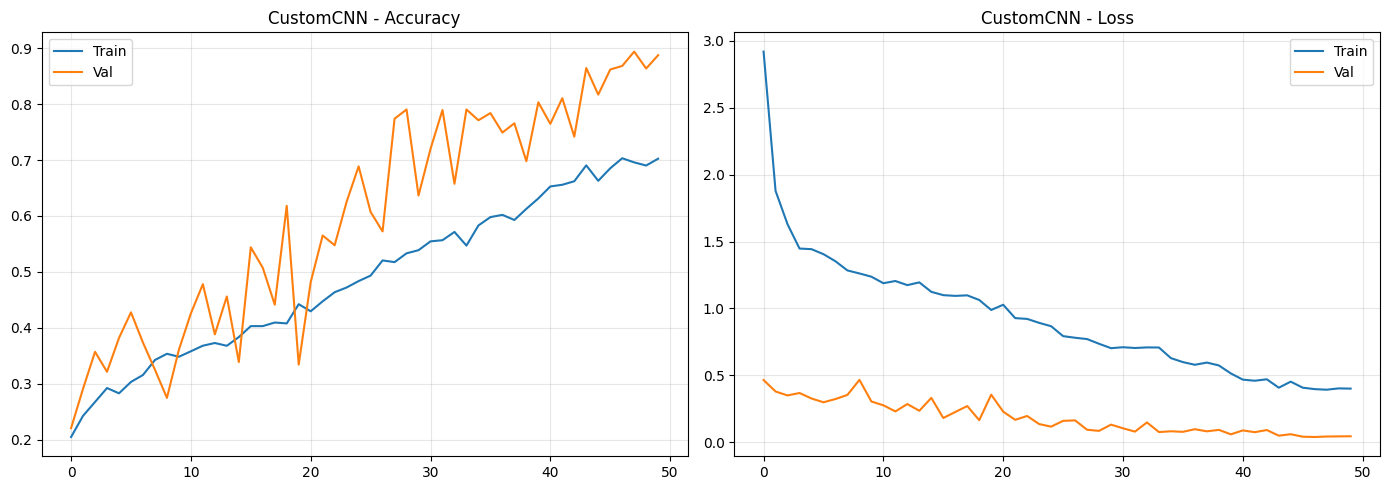

✓ Custom CNN training complete!


In [5]:
def build_custom_cnn():
    """
    Build Custom CNN from scratch
    """
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.25),
        
        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.25),
        
        # Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.25),
        
        # Block 4
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.3),
        
        # Classifier
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ], name='CustomCNN')
    
    return model

print("="*80)
print("TRAINING MODEL 1: CUSTOM CNN")
print("="*80)

cnn_model = build_custom_cnn()
cnn_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=focal_loss(),  # Using Focal Loss!
    metrics=['accuracy']
)

print("\nModel Architecture:")
cnn_model.summary()

print("\nStarting training...")
cnn_history = cnn_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=EPOCHS,
    class_weight=class_weight_dict,  # Using aggressive class weights!
    callbacks=get_callbacks('CustomCNN'),
    verbose=1
)

cnn_model.save('models/CustomCNN_final.h5')
plot_history(cnn_history, 'CustomCNN')
print("✓ Custom CNN training complete!")

## 3. Model 2: VGG16 (Transfer Learning)

In [6]:
def build_vgg16():
    """
    Build VGG16 with transfer learning
    """
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # Freeze base model
    base_model.trainable = False
    
    # Add custom classifier
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ], name='VGG16_TL')
    
    return model

print("="*80)
print("TRAINING MODEL 2: VGG16 (Transfer Learning)")
print("="*80)

vgg_model = build_vgg16()
vgg_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=focal_loss(),
    metrics=['accuracy']
)

print("\nStarting training...")
vgg_history = vgg_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=EPOCHS,
    class_weight=class_weight_dict,
    callbacks=get_callbacks('VGG16'),
    verbose=1
)

vgg_model.save('models/VGG16_final.h5')
plot_history(vgg_history, 'VGG16')
print("✓ VGG16 training complete!")

TRAINING MODEL 2: VGG16 (Transfer Learning)
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 85s 1us/step

Starting training...
Epoch 1/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1447 - loss: 1.7018
Epoch 1: val_accuracy improved from None to 0.37363, saving model to models/VGG16_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 1010s 3s/step - accuracy: 0.1791 - loss: 1.6638 - val_accuracy: 0.3736 - val_loss: 0.4007 - learning_rate: 1.0000e-04
Epoch 2/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2492 - loss: 1.4866
Epoch 2: val_accuracy improved from 0.37363 to 0.53938, saving model to models/VGG16_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 1121s 3s/step - accuracy: 0.2649 - loss: 1.4659 - val_accuracy: 0.5394 - val_loss: 0.3470 - learning_rate: 1.0000e-04
Epoch 3/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3068 - loss: 1.2969
Epoch 3: val_accuracy improved from 0.53938 to 0.65293, saving model to models/VGG16_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 1815s 5s/step - accuracy: 0.3226 - loss: 1.3221 - val_accuracy: 0.6529 - val_loss: 0.3051 - learning_rate: 1.0000e-04
Epoch 4/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3726 - loss: 1.1381
Epoch 4: val_accuracy improved from 0.65293 to 0.66941, saving model to models/VGG16_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 1271s 3s/step - accuracy: 0.3772 - loss: 1.2032 - val_accuracy: 0.6694 - val_loss: 0.2674 - learning_rate: 1.0000e-04
Epoch 5/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4273 - loss: 1.1230
Epoch 5: val_accuracy improved from 0.66941 to 0.69780, saving model to models/VGG16_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 911s 2s/step - accuracy: 0.4313 - loss: 1.0716 - val_accuracy: 0.6978 - val_loss: 0.2137 - learning_rate: 1.0000e-04
Epoch 6/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4529 - loss: 1.0149
Epoch 6: val_accuracy improved from 0.69780 to 0.75549, saving model to models/VGG16_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 895s 2s/step - accuracy: 0.4617 - loss: 0.9829 - val_accuracy: 0.7555 - val_loss: 0.1819 - learning_rate: 1.0000e-04
Epoch 7/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4889 - loss: 1.0573
Epoch 7: val_accuracy did not improve from 0.75549
390/390 ━━━━━━━━━━━━━━━━━━━━ 894s 2s/step - accuracy: 0.4999 - loss: 0.8711 - val_accuracy: 0.7289 - val_loss: 0.1592 - learning_rate: 1.0000e-04
Epoch 8/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5196 - loss: 0.7893
Epoch 8: val_accuracy did not improve from 0.75549
390/390 ━━━━━━━━━━━━━━━━━━━━ 888s 2s/step - accuracy: 0.5247 - loss: 0.7874 - val_accuracy: 0.7363 - val_loss: 0.1354 - learning_rate: 1.0000e-04
Epoch 9/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5315 - loss: 0.7424
Epoch 9: val_accuracy improved from 0.75549 to 0.78938, saving model to models/VGG16_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 883s 2s/step - accuracy: 0.5396 - loss: 0.7563 - val_accuracy: 0.7894 - val_loss: 0.1170 - learning_rate: 1.0000e-04
Epoch 10/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5746 - loss: 0.7460
Epoch 10: val_accuracy did not improve from 0.78938
390/390 ━━━━━━━━━━━━━━━━━━━━ 883s 2s/step - accuracy: 0.5809 - loss: 0.6907 - val_accuracy: 0.7692 - val_loss: 0.1110 - learning_rate: 1.0000e-04
Epoch 11/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5910 - loss: 0.6700
Epoch 11: val_accuracy did not improve from 0.78938
390/390 ━━━━━━━━━━━━━━━━━━━━ 1202s 3s/step - accuracy: 0.5870 - loss: 0.6523 - val_accuracy: 0.7821 - val_loss: 0.1025 - learning_rate: 1.0000e-04
Epoch 12/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6084 - loss: 0.6536
Epoch 12: val_accuracy did not improve from 0.78938
390/390 ━━━━━━━━━━━━━━━━━━━━ 1672s 4s/step - accuracy: 0.6125 - loss: 0.6078 - val_accuracy: 0.7885 - val_loss: 0.0943 - learning_rate: 1.0000e-04


390/390 ━━━━━━━━━━━━━━━━━━━━ 1633s 4s/step - accuracy: 0.6149 - loss: 0.5986 - val_accuracy: 0.7985 - val_loss: 0.0878 - learning_rate: 1.0000e-04
Epoch 14/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6459 - loss: 0.5073
Epoch 14: val_accuracy improved from 0.79853 to 0.81227, saving model to models/VGG16_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 936s 2s/step - accuracy: 0.6360 - loss: 0.5646 - val_accuracy: 0.8123 - val_loss: 0.0784 - learning_rate: 1.0000e-04
Epoch 15/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6424 - loss: 0.5393
Epoch 15: val_accuracy improved from 0.81227 to 0.83791, saving model to models/VGG16_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 936s 2s/step - accuracy: 0.6451 - loss: 0.5200 - val_accuracy: 0.8379 - val_loss: 0.0708 - learning_rate: 1.0000e-04
Epoch 16/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6554 - loss: 0.4899
Epoch 16: val_accuracy did not improve from 0.83791
390/390 ━━━━━━━━━━━━━━━━━━━━ 955s 2s/step - accuracy: 0.6508 - loss: 0.5099 - val_accuracy: 0.8095 - val_loss: 0.0776 - learning_rate: 1.0000e-04
Epoch 17/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6564 - loss: 0.4875
Epoch 17: val_accuracy did not improve from 0.83791
390/390 ━━━━━━━━━━━━━━━━━━━━ 920s 2s/step - accuracy: 0.6614 - loss: 0.4901 - val_accuracy: 0.8150 - val_loss: 0.0670 - learning_rate: 1.0000e-04
Epoch 18/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6707 - loss: 0.4918
Epoch 18: val_accuracy improved from 0.83791 to 0.85440, saving model to models/VGG16_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 913s 2s/step - accuracy: 0.6736 - loss: 0.4687 - val_accuracy: 0.8544 - val_loss: 0.0597 - learning_rate: 1.0000e-04
Epoch 19/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6866 - loss: 0.4384
Epoch 19: val_accuracy improved from 0.85440 to 0.85623, saving model to models/VGG16_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 922s 2s/step - accuracy: 0.6885 - loss: 0.4350 - val_accuracy: 0.8562 - val_loss: 0.0581 - learning_rate: 1.0000e-04
Epoch 20/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6952 - loss: 0.4177
Epoch 20: val_accuracy improved from 0.85623 to 0.86905, saving model to models/VGG16_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 913s 2s/step - accuracy: 0.6959 - loss: 0.4241 - val_accuracy: 0.8690 - val_loss: 0.0506 - learning_rate: 1.0000e-04
Epoch 21/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6995 - loss: 0.4321
Epoch 21: val_accuracy improved from 0.86905 to 0.87546, saving model to models/VGG16_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 912s 2s/step - accuracy: 0.7030 - loss: 0.4182 - val_accuracy: 0.8755 - val_loss: 0.0466 - learning_rate: 1.0000e-04
Epoch 22/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7088 - loss: 0.4272
Epoch 22: val_accuracy improved from 0.87546 to 0.88187, saving model to models/VGG16_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 1110s 3s/step - accuracy: 0.7160 - loss: 0.3974 - val_accuracy: 0.8819 - val_loss: 0.0445 - learning_rate: 1.0000e-04
Epoch 23/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7267 - loss: 0.4028
Epoch 23: val_accuracy did not improve from 0.88187
390/390 ━━━━━━━━━━━━━━━━━━━━ 1430s 4s/step - accuracy: 0.7218 - loss: 0.4013 - val_accuracy: 0.8764 - val_loss: 0.0485 - learning_rate: 1.0000e-04
Epoch 24/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7218 - loss: 0.3733
Epoch 24: val_accuracy did not improve from 0.88187
390/390 ━━━━━━━━━━━━━━━━━━━━ 1754s 4s/step - accuracy: 0.7240 - loss: 0.3580 - val_accuracy: 0.8782 - val_loss: 0.0424 - learning_rate: 1.0000e-04
Epoch 25/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7355 - loss: 0.3710
Epoch 25: val_accuracy did not improve from 0.88187
390/390 ━━━━━━━━━━━━━━━━━━━━ 942s 2s/step - accuracy: 0.7317 - loss: 0.3705 - val_accuracy: 0.8819 - val_loss: 0.0415 - learning_rate: 1.0000e-04

KeyboardInterrupt: 

## 4. Model 3: ResNet50 (Transfer Learning)

TRAINING MODEL 3: ResNet50 (Transfer Learning)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step

Starting training...
Epoch 1/25
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1101 - loss: 2.0052
Epoch 1: val_accuracy improved from None to 0.17125, saving model to models/ResNet50_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 509s 1s/step - accuracy: 0.1276 - loss: 1.8262 - val_accuracy: 0.1712 - val_loss: 0.4719 - learning_rate: 1.0000e-04
Epoch 2/25
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1482 - loss: 1.6698
Epoch 2: val_accuracy did not improve from 0.17125
390/390 ━━━━━━━━━━━━━━━━━━━━ 492s 1s/step - accuracy: 0.1425 - loss: 1.6955 - val_accuracy: 0.1712 - val_loss: 0.4729 - learning_rate: 1.0000e-04
Epoch 3/25
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1391 - loss: 1.6011
Epoch 3: val_accuracy did not improve from 0.17125
390/390 ━━━━━━━━━━━━━━━━━━━━ 495s 1s/step - accuracy: 0.1545 - loss: 1.6664 - val_accuracy: 0.1712 - val_loss: 0.4668 - learning_rate: 1.0000e-04
Epoch 4/25
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1632 - loss: 1.5427
Epoch 4: val_accuracy did not improve from 0.17125
390/390 ━━━━━━━━━━━━━━━━━━━━ 497s 1s/step - accuracy: 0.1651 - loss: 1.6485 - val_accuracy: 0.1712 - val_loss: 0.4627 - learning_rate: 1.0000e-04
Epoch 5/

390/390 ━━━━━━━━━━━━━━━━━━━━ 508s 1s/step - accuracy: 0.1716 - loss: 1.5930 - val_accuracy: 0.1758 - val_loss: 0.4392 - learning_rate: 1.0000e-04
Epoch 14/25
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1640 - loss: 1.6439
Epoch 14: val_accuracy improved from 0.17582 to 0.18590, saving model to models/ResNet50_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 507s 1s/step - accuracy: 0.1724 - loss: 1.5960 - val_accuracy: 0.1859 - val_loss: 0.4392 - learning_rate: 1.0000e-04
Epoch 15/25
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1628 - loss: 1.5107
Epoch 15: val_accuracy improved from 0.18590 to 0.20330, saving model to models/ResNet50_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 503s 1s/step - accuracy: 0.1682 - loss: 1.5956 - val_accuracy: 0.2033 - val_loss: 0.4372 - learning_rate: 1.0000e-04
Epoch 16/25
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1729 - loss: 1.4833
Epoch 16: val_accuracy did not improve from 0.20330
390/390 ━━━━━━━━━━━━━━━━━━━━ 491s 1s/step - accuracy: 0.1749 - loss: 1.5773 - val_accuracy: 0.1932 - val_loss: 0.4323 - learning_rate: 1.0000e-04
Epoch 17/25
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1909 - loss: 1.5845
Epoch 17: val_accuracy improved from 0.20330 to 0.24176, saving model to models/ResNet50_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 500s 1s/step - accuracy: 0.1835 - loss: 1.5709 - val_accuracy: 0.2418 - val_loss: 0.4365 - learning_rate: 1.0000e-04
Epoch 18/25
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1814 - loss: 1.5447
Epoch 18: val_accuracy did not improve from 0.24176
390/390 ━━━━━━━━━━━━━━━━━━━━ 493s 1s/step - accuracy: 0.1775 - loss: 1.5787 - val_accuracy: 0.2051 - val_loss: 0.4312 - learning_rate: 1.0000e-04
Epoch 19/25
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1733 - loss: 1.6153
Epoch 19: val_accuracy did not improve from 0.24176
390/390 ━━━━━━━━━━━━━━━━━━━━ 492s 1s/step - accuracy: 0.1786 - loss: 1.5672 - val_accuracy: 0.1777 - val_loss: 0.4237 - learning_rate: 1.0000e-04
Epoch 20/25
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1853 - loss: 1.5188
Epoch 20: val_accuracy did not improve from 0.24176
390/390 ━━━━━━━━━━━━━━━━━━━━ 493s 1s/step - accuracy: 0.1838 - loss: 1.5519 - val_accuracy: 0.2326 - val_loss: 0.4216 - learning_rate: 1.0000e-04
Ep

390/390 ━━━━━━━━━━━━━━━━━━━━ 491s 1s/step - accuracy: 0.1794 - loss: 1.5707 - val_accuracy: 0.2500 - val_loss: 0.4238 - learning_rate: 1.0000e-04
Epoch 23/25
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1964 - loss: 1.6141
Epoch 23: val_accuracy did not improve from 0.25000
390/390 ━━━━━━━━━━━━━━━━━━━━ 489s 1s/step - accuracy: 0.1888 - loss: 1.5560 - val_accuracy: 0.2152 - val_loss: 0.4206 - learning_rate: 1.0000e-04
Epoch 24/25
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1894 - loss: 1.4349
Epoch 24: val_accuracy improved from 0.25000 to 0.27564, saving model to models/ResNet50_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 493s 1s/step - accuracy: 0.1857 - loss: 1.5428 - val_accuracy: 0.2756 - val_loss: 0.4201 - learning_rate: 1.0000e-04
Epoch 25/25
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1939 - loss: 1.4177
Epoch 25: val_accuracy did not improve from 0.27564
390/390 ━━━━━━━━━━━━━━━━━━━━ 496s 1s/step - accuracy: 0.1915 - loss: 1.5422 - val_accuracy: 0.2051 - val_loss: 0.4205 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 24.


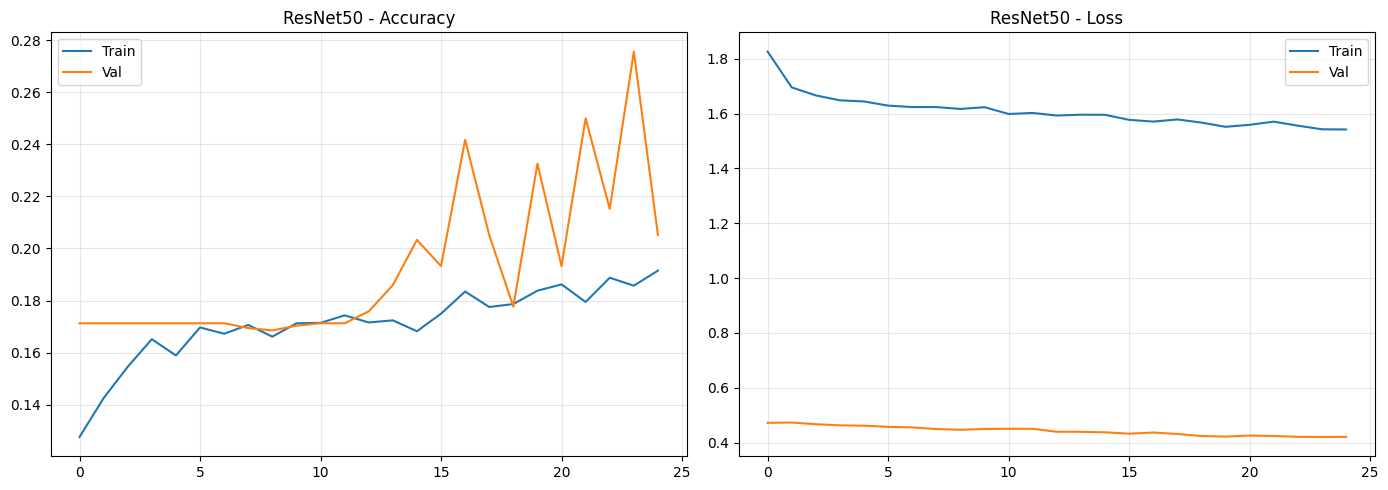

✓ ResNet50 training complete!


In [7]:
def build_resnet50():
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ], name='ResNet50_TL')
    
    return model

print("="*80)
print("TRAINING MODEL 3: ResNet50 (Transfer Learning)")
print("="*80)

resnet_model = build_resnet50()
resnet_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=focal_loss(),
    metrics=['accuracy']
)

print("\nStarting training...")
resnet_history = resnet_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=25,
    class_weight=class_weight_dict,
    callbacks=get_callbacks('ResNet50'),
    verbose=1
)

resnet_model.save('models/ResNet50_final.h5')
plot_history(resnet_history, 'ResNet50')
print("✓ ResNet50 training complete!")

## 5. Model 4: MobileNet (Transfer Learning)

TRAINING MODEL 4: MobileNet (Transfer Learning)

Starting training...
Epoch 1/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.2093 - loss: 1.9095
Epoch 1: val_accuracy improved from None to 0.83150, saving model to models/MobileNet_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 209s 528ms/step - accuracy: 0.3065 - loss: 1.4790 - val_accuracy: 0.8315 - val_loss: 0.1680 - learning_rate: 1.0000e-04
Epoch 2/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.4806 - loss: 0.8066
Epoch 2: val_accuracy improved from 0.83150 to 0.91850, saving model to models/MobileNet_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 283s 726ms/step - accuracy: 0.5304 - loss: 0.8194 - val_accuracy: 0.9185 - val_loss: 0.0588 - learning_rate: 1.0000e-04
Epoch 3/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.6136 - loss: 0.6970
Epoch 3: val_accuracy improved from 0.91850 to 0.94322, saving model to models/MobileNet_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 242s 621ms/step - accuracy: 0.6387 - loss: 0.5913 - val_accuracy: 0.9432 - val_loss: 0.0314 - learning_rate: 1.0000e-04
Epoch 4/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.7142 - loss: 0.4078
Epoch 4: val_accuracy improved from 0.94322 to 0.95330, saving model to models/MobileNet_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 210s 538ms/step - accuracy: 0.7110 - loss: 0.4230 - val_accuracy: 0.9533 - val_loss: 0.0181 - learning_rate: 1.0000e-04
Epoch 5/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.7433 - loss: 0.3557
Epoch 5: val_accuracy improved from 0.95330 to 0.96154, saving model to models/MobileNet_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 250s 506ms/step - accuracy: 0.7542 - loss: 0.3459 - val_accuracy: 0.9615 - val_loss: 0.0145 - learning_rate: 1.0000e-04
Epoch 6/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.7771 - loss: 0.3167
Epoch 6: val_accuracy improved from 0.96154 to 0.96245, saving model to models/MobileNet_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 235s 604ms/step - accuracy: 0.7891 - loss: 0.2995 - val_accuracy: 0.9625 - val_loss: 0.0122 - learning_rate: 1.0000e-04
Epoch 7/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.8070 - loss: 0.2659
Epoch 7: val_accuracy improved from 0.96245 to 0.97527, saving model to models/MobileNet_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 286s 734ms/step - accuracy: 0.8084 - loss: 0.2468 - val_accuracy: 0.9753 - val_loss: 0.0080 - learning_rate: 1.0000e-04
Epoch 8/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.8172 - loss: 0.2342
Epoch 8: val_accuracy did not improve from 0.97527
390/390 ━━━━━━━━━━━━━━━━━━━━ 202s 519ms/step - accuracy: 0.8204 - loss: 0.2269 - val_accuracy: 0.9725 - val_loss: 0.0083 - learning_rate: 1.0000e-04
Epoch 9/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.8365 - loss: 0.2327
Epoch 9: val_accuracy improved from 0.97527 to 0.97985, saving model to models/MobileNet_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 201s 516ms/step - accuracy: 0.8410 - loss: 0.2117 - val_accuracy: 0.9799 - val_loss: 0.0063 - learning_rate: 1.0000e-04
Epoch 10/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.8442 - loss: 0.2096
Epoch 10: val_accuracy improved from 0.97985 to 0.98077, saving model to models/MobileNet_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 205s 526ms/step - accuracy: 0.8435 - loss: 0.1922 - val_accuracy: 0.9808 - val_loss: 0.0056 - learning_rate: 1.0000e-04
Epoch 11/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.8532 - loss: 0.1621
Epoch 11: val_accuracy did not improve from 0.98077
390/390 ━━━━━━━━━━━━━━━━━━━━ 204s 524ms/step - accuracy: 0.8520 - loss: 0.1753 - val_accuracy: 0.9734 - val_loss: 0.0066 - learning_rate: 1.0000e-04
Epoch 12/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.8720 - loss: 0.1774
Epoch 12: val_accuracy improved from 0.98077 to 0.98626, saving model to models/MobileNet_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 202s 518ms/step - accuracy: 0.8700 - loss: 0.1719 - val_accuracy: 0.9863 - val_loss: 0.0047 - learning_rate: 1.0000e-04
Epoch 13/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.8804 - loss: 0.1350
Epoch 13: val_accuracy improved from 0.98626 to 0.98718, saving model to models/MobileNet_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 202s 517ms/step - accuracy: 0.8827 - loss: 0.1503 - val_accuracy: 0.9872 - val_loss: 0.0045 - learning_rate: 1.0000e-04
Epoch 14/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.8892 - loss: 0.1368
Epoch 14: val_accuracy did not improve from 0.98718
390/390 ━━━━━━━━━━━━━━━━━━━━ 202s 518ms/step - accuracy: 0.8903 - loss: 0.1450 - val_accuracy: 0.9799 - val_loss: 0.0046 - learning_rate: 1.0000e-04
Epoch 15/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.8928 - loss: 0.1471
Epoch 15: val_accuracy did not improve from 0.98718
390/390 ━━━━━━━━━━━━━━━━━━━━ 201s 516ms/step - accuracy: 0.8978 - loss: 0.1271 - val_accuracy: 0.9872 - val_loss: 0.0038 - learning_rate: 1.0000e-04
Epoch 16/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.8998 - loss: 0.1179
Epoch 16: val_accuracy did not improve from 0.98718
390/390 ━━━━━━━━━━━━━━━━━━━━ 202s 519ms/step - accuracy: 0.8965 - loss: 0.1174 - val_accuracy: 0.9817 - val_loss: 0.0044 - learnin

390/390 ━━━━━━━━━━━━━━━━━━━━ 201s 516ms/step - accuracy: 0.9081 - loss: 0.1161 - val_accuracy: 0.9908 - val_loss: 0.0030 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 20.


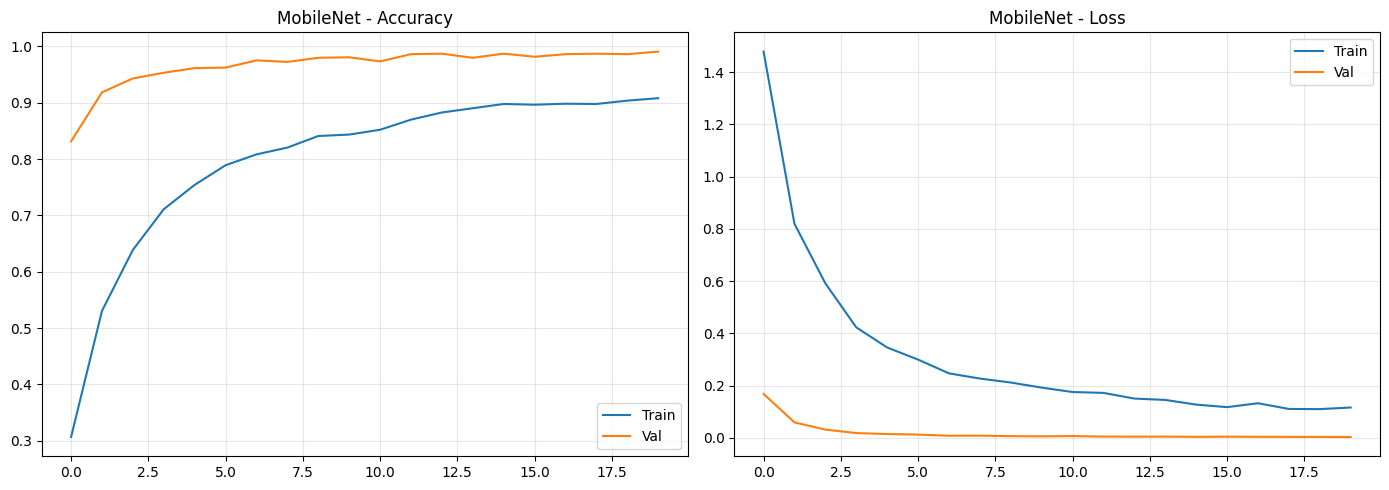

✓ MobileNet training complete!


In [10]:
def build_mobilenet():
    base_model = MobileNet(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ], name='MobileNet_TL')
    
    return model

print("="*80)
print("TRAINING MODEL 4: MobileNet (Transfer Learning)")
print("="*80)

mobilenet_model = build_mobilenet()
mobilenet_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=focal_loss(),
    metrics=['accuracy']
)

print("\nStarting training...")
mobilenet_history = mobilenet_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=get_callbacks('MobileNet'),
    verbose=1
)

mobilenet_model.save('models/MobileNet_final.h5')
plot_history(mobilenet_history, 'MobileNet')
print("✓ MobileNet training complete!")

## 6. Model 5: InceptionV3 (Transfer Learning)

TRAINING MODEL 5: InceptionV3 (Transfer Learning)

Starting training...
Epoch 1/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.2246 - loss: 1.7363
Epoch 1: val_accuracy improved from None to 0.73626, saving model to models/InceptionV3_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 311s 774ms/step - accuracy: 0.3113 - loss: 1.4326 - val_accuracy: 0.7363 - val_loss: 0.1723 - learning_rate: 1.0000e-04
Epoch 2/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.4755 - loss: 0.8661
Epoch 2: val_accuracy improved from 0.73626 to 0.77198, saving model to models/InceptionV3_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 287s 735ms/step - accuracy: 0.5144 - loss: 0.8697 - val_accuracy: 0.7720 - val_loss: 0.0962 - learning_rate: 1.0000e-04
Epoch 3/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.6044 - loss: 0.6970
Epoch 3: val_accuracy improved from 0.77198 to 0.86447, saving model to models/InceptionV3_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 288s 739ms/step - accuracy: 0.6047 - loss: 0.6866 - val_accuracy: 0.8645 - val_loss: 0.0624 - learning_rate: 1.0000e-04
Epoch 4/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.6420 - loss: 0.6037
Epoch 4: val_accuracy improved from 0.86447 to 0.86722, saving model to models/InceptionV3_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 285s 731ms/step - accuracy: 0.6557 - loss: 0.5414 - val_accuracy: 0.8672 - val_loss: 0.0498 - learning_rate: 1.0000e-04
Epoch 5/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.6710 - loss: 0.5876
Epoch 5: val_accuracy improved from 0.86722 to 0.88187, saving model to models/InceptionV3_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 284s 729ms/step - accuracy: 0.6808 - loss: 0.5116 - val_accuracy: 0.8819 - val_loss: 0.0434 - learning_rate: 1.0000e-04
Epoch 6/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.6930 - loss: 0.4262
Epoch 6: val_accuracy did not improve from 0.88187
390/390 ━━━━━━━━━━━━━━━━━━━━ 283s 725ms/step - accuracy: 0.6896 - loss: 0.4625 - val_accuracy: 0.8764 - val_loss: 0.0421 - learning_rate: 1.0000e-04
Epoch 7/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.7005 - loss: 0.4523
Epoch 7: val_accuracy improved from 0.88187 to 0.90110, saving model to models/InceptionV3_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 283s 725ms/step - accuracy: 0.7134 - loss: 0.4336 - val_accuracy: 0.9011 - val_loss: 0.0373 - learning_rate: 1.0000e-04
Epoch 8/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.7534 - loss: 0.3323
Epoch 8: val_accuracy improved from 0.90110 to 0.91026, saving model to models/InceptionV3_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 343s 881ms/step - accuracy: 0.7478 - loss: 0.3492 - val_accuracy: 0.9103 - val_loss: 0.0300 - learning_rate: 1.0000e-04
Epoch 9/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 0.7539 - loss: 0.3126
Epoch 9: val_accuracy did not improve from 0.91026
390/390 ━━━━━━━━━━━━━━━━━━━━ 315s 809ms/step - accuracy: 0.7468 - loss: 0.3520 - val_accuracy: 0.9103 - val_loss: 0.0288 - learning_rate: 1.0000e-04
Epoch 10/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.7475 - loss: 0.3505
Epoch 10: val_accuracy improved from 0.91026 to 0.92582, saving model to models/InceptionV3_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 284s 727ms/step - accuracy: 0.7533 - loss: 0.3418 - val_accuracy: 0.9258 - val_loss: 0.0245 - learning_rate: 1.0000e-04
Epoch 11/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.7639 - loss: 0.3087
Epoch 11: val_accuracy did not improve from 0.92582
390/390 ━━━━━━━━━━━━━━━━━━━━ 286s 733ms/step - accuracy: 0.7690 - loss: 0.3275 - val_accuracy: 0.8947 - val_loss: 0.0351 - learning_rate: 1.0000e-04
Epoch 12/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.7611 - loss: 0.3532
Epoch 12: val_accuracy did not improve from 0.92582
390/390 ━━━━━━━━━━━━━━━━━━━━ 288s 738ms/step - accuracy: 0.7727 - loss: 0.3178 - val_accuracy: 0.9057 - val_loss: 0.0271 - learning_rate: 1.0000e-04
Epoch 13/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.7770 - loss: 0.2818
Epoch 13: val_accuracy did not improve from 0.92582
390/390 ━━━━━━━━━━━━━━━━━━━━ 286s 734ms/step - accuracy: 0.7741 - loss: 0.3014 - val_accuracy: 0.9222 - val_loss: 0.0276 - learnin

390/390 ━━━━━━━━━━━━━━━━━━━━ 289s 740ms/step - accuracy: 0.8003 - loss: 0.2643 - val_accuracy: 0.9441 - val_loss: 0.0194 - learning_rate: 1.0000e-04
Epoch 16/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.8016 - loss: 0.2755
Epoch 16: val_accuracy did not improve from 0.94414
390/390 ━━━━━━━━━━━━━━━━━━━━ 286s 734ms/step - accuracy: 0.8034 - loss: 0.2635 - val_accuracy: 0.9304 - val_loss: 0.0206 - learning_rate: 1.0000e-04
Epoch 17/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.8171 - loss: 0.2738
Epoch 17: val_accuracy did not improve from 0.94414
390/390 ━━━━━━━━━━━━━━━━━━━━ 287s 737ms/step - accuracy: 0.8182 - loss: 0.2443 - val_accuracy: 0.9359 - val_loss: 0.0188 - learning_rate: 1.0000e-04
Epoch 18/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.8082 - loss: 0.2836
Epoch 18: val_accuracy did not improve from 0.94414
390/390 ━━━━━━━━━━━━━━━━━━━━ 282s 723ms/step - accuracy: 0.8164 - loss: 0.2543 - val_accuracy: 0.9432 - val_loss: 0.0170 - learnin

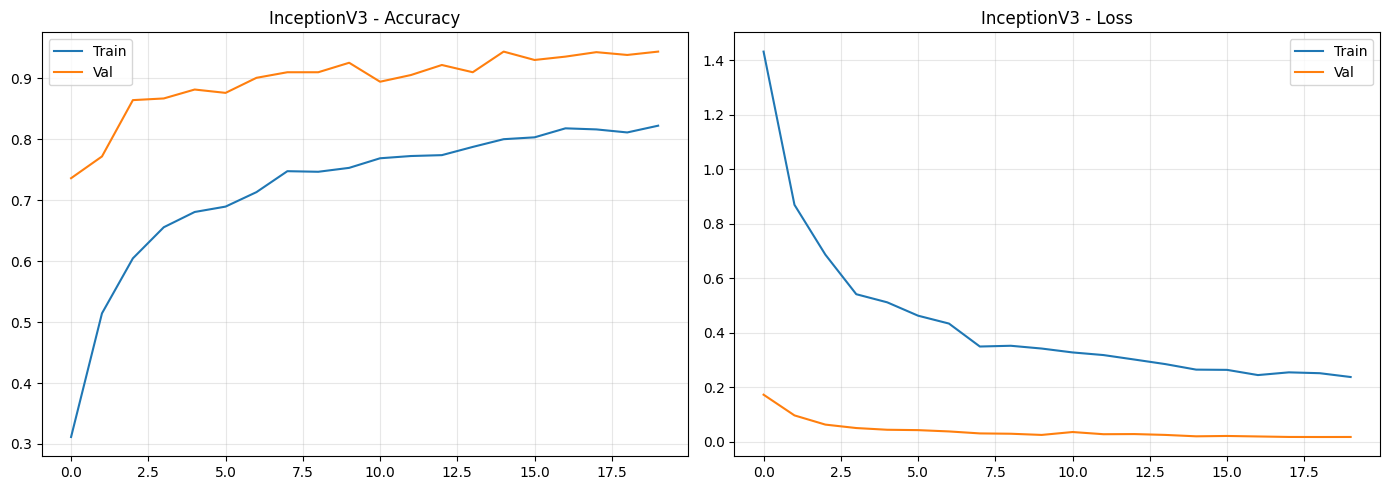

✓ InceptionV3 training complete!


In [12]:
def build_inception():
    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ], name='InceptionV3_TL')
    
    return model

print("="*80)
print("TRAINING MODEL 5: InceptionV3 (Transfer Learning)")
print("="*80)

inception_model = build_inception()
inception_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=focal_loss(),
    metrics=['accuracy']
)

print("\nStarting training...")
inception_history = inception_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=get_callbacks('InceptionV3'),
    verbose=1
)

inception_model.save('models/InceptionV3_final.h5')
plot_history(inception_history, 'InceptionV3')
print("✓ InceptionV3 training complete!")

## 7. Model 6: EfficientNetB0 (Transfer Learning)

TRAINING MODEL 6: EfficientNetV2B0 (Transfer Learning)
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

Starting training...
Epoch 1/30
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1341 - loss: 1.8015
Epoch 1: val_accuracy improved from None to 0.17125, saving model to models/EfficientNetV2B0_best.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 610s 2s/step - accuracy: 0.1365 - loss: 1.7044 - val_accuracy: 0.1712 - val_loss: 0.4750 - learning_rate: 1.0000e-04
Epoch 2/30
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1469 - loss: 1.5792
Epoch 2: val_accuracy did not improve from 0.17125
390/390 ━━━━━━━━━━━━━━━━━━━━ 555s 1s/step - accuracy: 0.1528 - loss: 1.6811 - val_accuracy: 0.1712 - val_loss: 0.4767 - learning_rate: 1.0000e-04
Epoch 3/30
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.1655 - loss: 1.7902
Epoch 3: val_accuracy did not improve from 0.17125
390/390 ━━━━━━━━━━━━━━━━━━━━ 358s 916ms/step - accuracy: 0.1667 - loss: 1.6701 - val_accuracy: 0.1712 - val_loss: 0.4754 - learning_rate: 1.0000e-04
Epoch 4/30
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.1636 - loss: 1.8056
Epoch 4: val_accuracy did not improve from 0.17125
390/390 ━━━━━━━━━━━━━━━━━━━━ 262s 672ms/step - accuracy: 0.1672 - loss: 1.6645 - val_accuracy: 0.1712 - val_loss: 0.4734 - learning_rate: 1.0000e

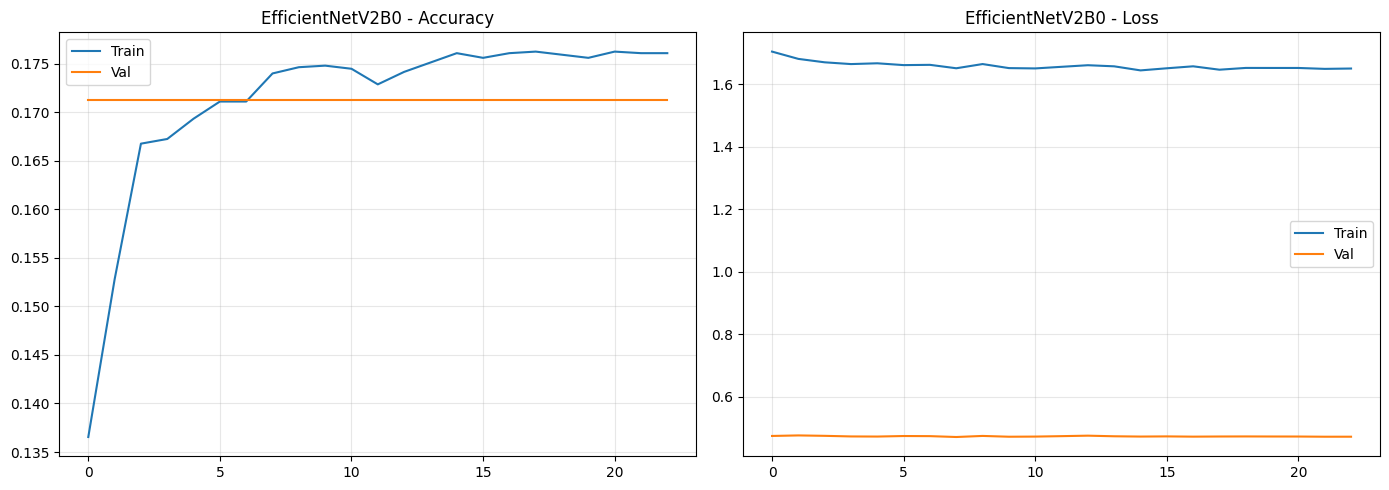

✓ EfficientNetV2B0 training complete!


In [6]:
from tensorflow.keras.applications import EfficientNetV2B0
def build_efficientnet():
    base_model = EfficientNetV2B0(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ], name='EfficientNetV2B0_TL')
    
    return model

print("="*80)
print("TRAINING MODEL 6: EfficientNetV2B0 (Transfer Learning)")
print("="*80)

try:
    efficientnet_model = build_efficientnet()
    efficientnet_model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss=focal_loss(),
        metrics=['accuracy']
    )

    print("\nStarting training...")
    efficientnet_history = efficientnet_model.fit(
        train_gen,
        validation_data=valid_gen,
        epochs=30,
        class_weight=class_weight_dict,
        callbacks=get_callbacks('EfficientNetV2B0'),
        verbose=1
    )

    efficientnet_model.save('models/EfficientNetV2B0_final.h5')
    plot_history(efficientnet_history, 'EfficientNetV2B0')
    print("✓ EfficientNetV2B0 training complete!")
    
except Exception as e:
    print(f"EfficientNet training failed: {e}")

## Summary

### All Models Trained!

✅ Custom CNN
✅ VGG16
✅ ResNet50
✅ MobileNet
✅ InceptionV3
✅ EfficientNetB0

### All models saved in `models/` directory:
- `*_best.h5` (best model during training)
- `*_final.h5` (final model after training)

### Training histories saved in `results/metrics/`
### Training plots saved in `results/plots/`

### Next Steps:
- Proceed to Part 4 for model evaluation and comparison